In [1]:
import os
from PIL import Image

def load_dataset(dataset_path):
    images = []
    labels = []
    
    # Get class names and clean them
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    classes = [name.replace('_dataset', '') for name in classes]  # Remove '_dataset' from names
    
    # Create class to index mapping
    class_to_idx = {name + '_dataset' if 'dataset' in orig_name else name: idx 
                   for idx, (name, orig_name) in enumerate(zip(classes, sorted([d for d in os.listdir(dataset_path) 
                   if os.path.isdir(os.path.join(dataset_path, d))])))}
    
    # Load images and labels
    for orig_class in os.listdir(dataset_path):
        if os.path.isdir(os.path.join(dataset_path, orig_class)):
            class_path = os.path.join(dataset_path, orig_class)
            class_idx = class_to_idx[orig_class]
            
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    img = Image.open(img_path).convert('RGB')
                    images.append(img)
                    labels.append(class_idx)
    
    return images, labels, classes

dataset_path = "NDD_DATASET"
images, labels, classes = load_dataset(dataset_path)
print(f"Number of images loaded: {len(images)}")
print(f"Classes found: {classes}")

Number of images loaded: 7590
Classes found: ['alzheimers', 'normal', 'parkinsons']


In [2]:
def resize_images_to_minimally_divisible_by_8(images):
    resized_images = []
    for img in images:
        # Get original dimensions
        width, height = img.size
        
        # Calculate the new dimensions by reducing minimally to make them divisible by 8
        new_width = width - (width % 8)
        new_height = height - (height % 8)
        
        # Check if resizing is needed
        if width != new_width or height != new_height:
            print(f"Original size: {width}x{height} -> New size: {new_width}x{new_height}")
        
        # Crop the image to the new dimensions
        resized_img = img.crop((0, 0, new_width, new_height))
        resized_images.append(resized_img)
    
    return resized_images

# Resize all images to make their dimensions divisible by 8 and log changes
resized_images = resize_images_to_minimally_divisible_by_8(images)

# Check that all images are now divisible by 8
for idx, img in enumerate(resized_images):
    width, height = img.size
    assert width % 8 == 0 and height % 8 == 0, f"Image at index {idx} is not divisible by 8!"

print("All images resized to dimensions minimally divisible by 8.")


Original size: 250x320 -> New size: 248x320
Original size: 364x448 -> New size: 360x448
Original size: 364x448 -> New size: 360x448
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 364x448 -> New size: 360x448
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 260x320 -> New size: 256x320
Original size: 250x320 -> New size: 248x320
Original size: 260x320 -> New size: 256x320
Original size: 260x320 -> New size: 256x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 364x448 -> New si

In [3]:
import torch
from torchvision import transforms

def normalize_and_convert_to_tensor(images):
    """
    Normalize and convert a list of PIL images to PyTorch tensors.
    """
    # Define the transformation: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Imagenet dataset.
    ])
    # Apply the transform to each image
    tensors = [transform(img) for img in images]
    return tensors

# Normalize and convert resized images to tensors
tensors = normalize_and_convert_to_tensor(resized_images)

# Log some details for verification
for i, tensor in enumerate(tensors[:5]):  # Print details of the first 5 tensors
    print(f"Image {i+1}: Shape = {tensor.shape}, Min = {torch.min(tensor):.3f}, Max = {torch.max(tensor):.3f}")

print(f"Total tensors created: {len(tensors)}")


Image 1: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.588
Image 2: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.640
Image 3: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.274
Image 4: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.640
Image 5: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.623
Total tensors created: 7590


In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define your transforms here
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Split data into train, validation, and test sets (80:10:10)
train_images, test_images, train_labels, test_labels = train_test_split(
    resized_images, labels, test_size=0.2, random_state=42, stratify=labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

# Create datasets for each split
train_dataset = CustomImageDataset(images=train_images, labels=train_labels, transform=transform)
val_dataset = CustomImageDataset(images=val_images, labels=val_labels, transform=transform)
test_dataset = CustomImageDataset(images=test_images, labels=test_labels, transform=transform)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Checking DataLoader
for images, labels in train_loader:
    print(images.shape)  # Should print batch size and dimensions
    break


torch.Size([16, 3, 224, 224])


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load ResNet-101 with pretrained weights from ImageNet
model = models.resnet101(pretrained=True)

# Modify the final fully connected layer to output 3 classes (Alzheimer’s, Parkinson’s, Normal)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes


/dgxa_home/se21uari192/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dgxa_home/se21uari192/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Loss Function: CrossEntropyLoss (suitable for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam optimizer (can use other optimizers like SGD as well)
optimizer = optim.Adam(model.parameters(), lr=0.000001)


Epoch 1/50
Train Loss: 0.7004, Train Accuracy: 0.7050
Validation Loss: 0.5134, Validation Accuracy: 0.7879
Validation loss improved. Model saved.
Epoch 2/50
Train Loss: 0.4578, Train Accuracy: 0.8188
Validation Loss: 0.3948, Validation Accuracy: 0.8379
Validation loss improved. Model saved.
Epoch 3/50
Train Loss: 0.3674, Train Accuracy: 0.8460
Validation Loss: 0.3232, Validation Accuracy: 0.8630
Validation loss improved. Model saved.
Epoch 4/50
Train Loss: 0.2990, Train Accuracy: 0.8809
Validation Loss: 0.2859, Validation Accuracy: 0.8827
Validation loss improved. Model saved.
Epoch 5/50
Train Loss: 0.2518, Train Accuracy: 0.9015
Validation Loss: 0.2404, Validation Accuracy: 0.9012
Validation loss improved. Model saved.
Epoch 6/50
Train Loss: 0.1976, Train Accuracy: 0.9341
Validation Loss: 0.2009, Validation Accuracy: 0.9275
Validation loss improved. Model saved.
Epoch 7/50
Train Loss: 0.1558, Train Accuracy: 0.9516
Validation Loss: 0.1765, Validation Accuracy: 0.9302
Validation loss i

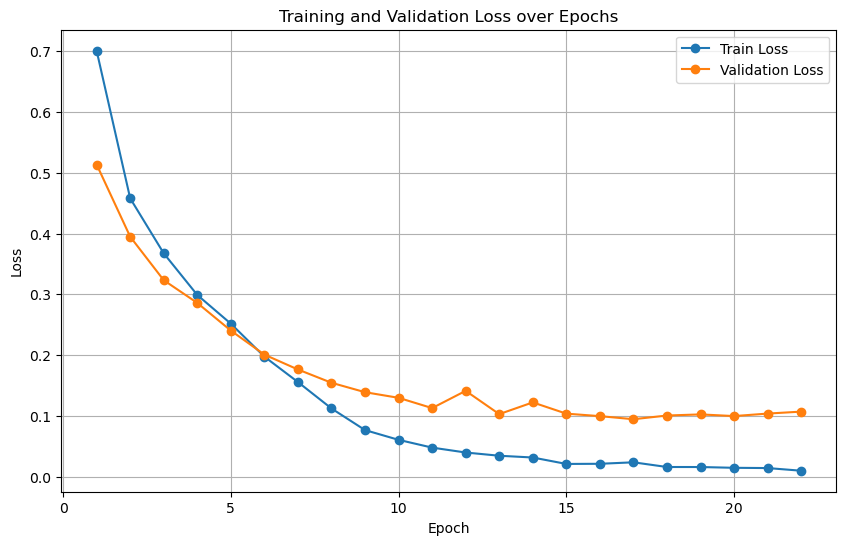

In [7]:
import torch
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)
    
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / total_preds
    return epoch_loss, epoch_accuracy

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)
    
    eval_loss = running_loss / len(dataloader)
    eval_accuracy = correct_preds / total_preds
    return eval_loss, eval_accuracy

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float('inf')  # Initialize best validation loss to infinity
counter = 0  # Counter for early stopping

# Initialize lists to store losses for each epoch
train_losses = []
val_losses = []

# Training loop with loss tracking and early stopping
num_epochs = 50  # Set a high number of epochs to test early stopping
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
    # Validation
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_Resnet_model_2.pth")
        print("Validation loss improved. Model saved.")
    else:
        counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {counter}/{patience}")
        
        if counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# # Evaluate on the test set
# model.eval()  # Set to evaluation mode

# test_accuracy = 0
# test_loss = 0

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.cuda(), labels.cuda()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Calculate accuracy
#         _, predicted = torch.max(outputs, 1)
#         correct = (predicted == labels).sum().item()
#         test_accuracy += correct
#         test_loss += loss.item()

#     test_accuracy = 100 * test_accuracy / len(test_loader.dataset)
#     print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
# Testing Phase
model.eval()
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test_predictions += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct_test_predictions / total_test_predictions
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 96.97%


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Initialize containers for predictions and ground truth
all_predictions = []
all_labels = []

# Evaluate the model and collect predictions and labels
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate overall accuracy
test_accuracy = 100 * (all_predictions == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {test_accuracy:.6f}%")

# Compute metrics
precision = precision_score(all_labels, all_predictions, average='weighted')  # Weighted average for multi-class
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=classes))  # Replace `class_names` with your class labels

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)


Test Accuracy: 96.969697%
Precision: 0.970305
Recall: 0.969697
F1-Score: 0.969708

Classification Report:
              precision    recall  f1-score   support

  alzheimers       0.93      0.98      0.95       250
      normal       0.98      0.94      0.96       270
  parkinsons       1.00      1.00      1.00       239

    accuracy                           0.97       759
   macro avg       0.97      0.97      0.97       759
weighted avg       0.97      0.97      0.97       759


Confusion Matrix:
[[244   6   0]
 [ 17 253   0]
 [  0   0 239]]


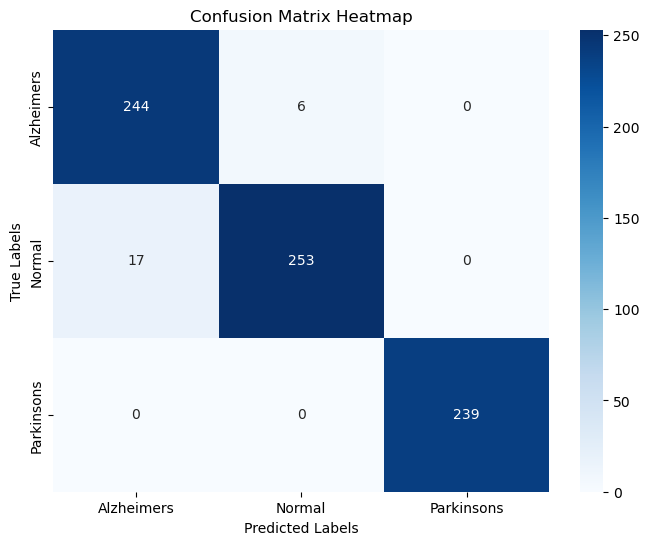

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Define class names for the heatmap
class_names = ['Alzheimers', 'Normal', 'Parkinsons']  # Replace with your actual class names

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and adjust axis
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
